## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

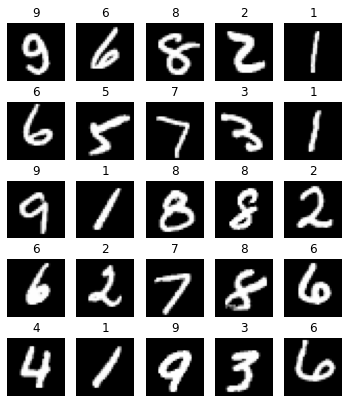

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [25]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    

sizes = [28*28] + [500]*10 + [10]
layers = []
for ind, outd in zip(sizes, sizes[1:]):
  layer = nn.Linear(ind, outd)
  init_layer(layer, 0.0, 0.1)
  layer.register_forward_hook(forward_hook)
  layer.register_backward_hook(backward_hook)
  layers.append(layer)
  layers.append(nn.Tanh())

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [26]:
network = nn.Sequential(*layers[:-1])

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9827849268913269
forward 0.8451936841011047
forward 0.7873530387878418
forward 0.7723914980888367
forward 0.7660092711448669
forward 0.7641626000404358
forward 0.7642450332641602
forward 0.7620433568954468
forward 0.764987051486969
forward 0.765868067741394
forward 0.7650426626205444
backward 0.03299831598997116
backward 0.014189787209033966
backward 0.013425351120531559
backward 0.012822460383176804
backward 0.012946506030857563
backward 0.013617447577416897
backward 0.016216302290558815
backward 0.018213514238595963
backward 0.021214980632066727
backward 0.027780890464782715
backward 0.026319101452827454


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [27]:
def xavier_layer(layer, first=1, second=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    a = (6/(first + second))**0.5
    weight.uniform_(-a, a)

In [29]:
sizes = [28*28] + [500]*10 + [10]
layers = []
for ind, outd in zip(sizes, sizes[1:]):
  layer = nn.Linear(ind, outd)
  xavier_layer(layer, ind, outd)
  layer.register_forward_hook(forward_hook)
  layer.register_backward_hook(backward_hook)
  layers.append(layer)
  layers.append(nn.Tanh())

In [30]:
network = nn.Sequential(*layers[:-1])

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9827849268913269
forward 0.6485199928283691
forward 0.49498793482780457
forward 0.4184989333152771
forward 0.3646484911441803
forward 0.3273117244243622
forward 0.298256516456604
forward 0.27323809266090393
forward 0.26277896761894226
forward 0.24751564860343933
forward 0.23343753814697266
backward 0.03299831598997116
backward 0.01956852152943611
backward 0.01801239512860775
backward 0.016733163967728615
backward 0.015654336661100388
backward 0.013857758603990078
backward 0.012521057389676571
backward 0.010873076505959034
backward 0.009258958511054516
backward 0.007617911323904991
backward 0.0045797755010426044


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [33]:
sizes = [28*28] + [500]*10 + [10]
layers = []
for ind, outd in zip(sizes, sizes[1:]):
  layer = nn.Linear(ind, outd)
  init_layer(layer, 0, (2/ind)**0.5)
  layer.register_forward_hook(forward_hook)
  layer.register_backward_hook(backward_hook)
  layers.append(layer)
  layers.append(nn.ReLU())

In [34]:
network = nn.Sequential(*layers[:-1])

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9827849268913269
forward 0.8492295742034912
forward 0.8426875472068787
forward 0.8295711278915405
forward 0.8359733819961548
forward 0.8781657218933105
forward 0.8837423324584961
forward 0.9023078680038452
forward 0.9511368870735168
forward 0.9202731847763062
forward 0.9305314421653748
backward 0.03299831598997116
backward 0.014620362780988216
backward 0.012271442450582981
backward 0.011466939002275467
backward 0.010486982762813568
backward 0.009322593919932842
backward 0.008556867949664593
backward 0.008024501614272594
backward 0.007763860747218132
backward 0.00708581879734993
backward 0.0065337237901985645


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [48]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        P = torch.ones_like(self.linear.weight) * (1 - self.p)
        if self.training:
            mask = P.bernoulli_()
        else:
            mask = P

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [36]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [41]:
layers = [nn.Dropout() ,nn.Linear(196, 128), nn.ReLU(), nn.Dropout(), nn.Linear(128, 128), nn.ReLU(), nn.Dropout(), nn.Linear(128, 10), nn.ReLU()]

Epoch 9... (Train/Test) NLL: 0.358/0.139	Accuracy: 0.891/0.957


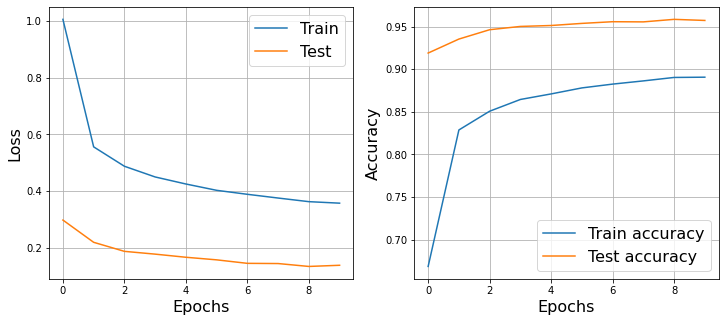

([1.0048488897682508,
  0.556049394709215,
  0.4877972658763308,
  0.4501227329153496,
  0.42532485462963454,
  0.4030863100023412,
  0.3890428945644578,
  0.37591169107316147,
  0.3631633149662506,
  0.3578551089140906],
 [0.29839606092700477,
  0.22009372805492788,
  0.18826960932604875,
  0.17845173878005788,
  0.16745251718955703,
  0.15835805416484422,
  0.14605294894191284,
  0.1453397426329836,
  0.13513032629897323,
  0.1392483198661593],
 [0.66849345,
  0.82871354,
  0.8507241,
  0.86451113,
  0.8710299,
  0.8780817,
  0.88254595,
  0.8863162,
  0.8903696,
  0.89067495],
 [0.9190071,
  0.93542325,
  0.94640034,
  0.9502571,
  0.9513449,
  0.95381725,
  0.9557951,
  0.9555973,
  0.9585641,
  0.9572785])

In [42]:
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.180/0.090	Accuracy: 0.947/0.973


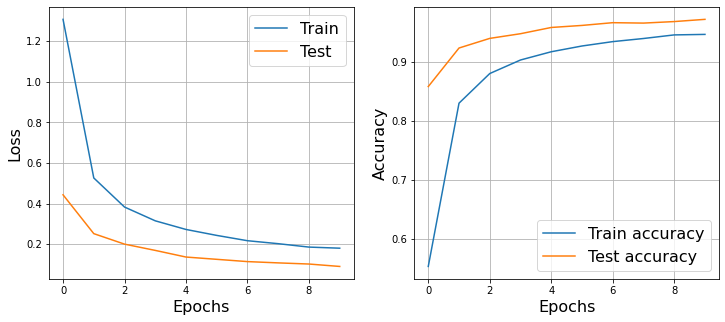

([1.3073661981869353,
  0.5262271430510194,
  0.38298701261406515,
  0.31511016091558214,
  0.27258154100128834,
  0.24327164665976567,
  0.21714754726713908,
  0.20248029641568788,
  0.18574546827182079,
  0.18032949798301592],
 [0.4432512419887736,
  0.25198882271217393,
  0.20032552667433703,
  0.16941999587454373,
  0.1367088175154751,
  0.12548023259526567,
  0.11429406375966117,
  0.10793899579704562,
  0.10229885041760871,
  0.09042310320972642],
 [0.5539823,
  0.8305349,
  0.8807303,
  0.90366805,
  0.9176273,
  0.9273832,
  0.9347903,
  0.9400708,
  0.9461676,
  0.94703376],
 [0.85868275,
  0.92395175,
  0.940269,
  0.9481804,
  0.9587619,
  0.9622231,
  0.966871,
  0.9661788,
  0.96875,
  0.9725079])

In [49]:
layers = [DropConnect(196, 128), nn.ReLU(), DropConnect(128, 128), nn.ReLU(), DropConnect(128, 10), nn.ReLU()]
network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [71]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - torch.mean(x, dim=1).reshape(x.size(0), -1)) / torch.std(x, dim=1).reshape(x.size(0), -1)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.024/0.062	Accuracy: 0.992/0.983


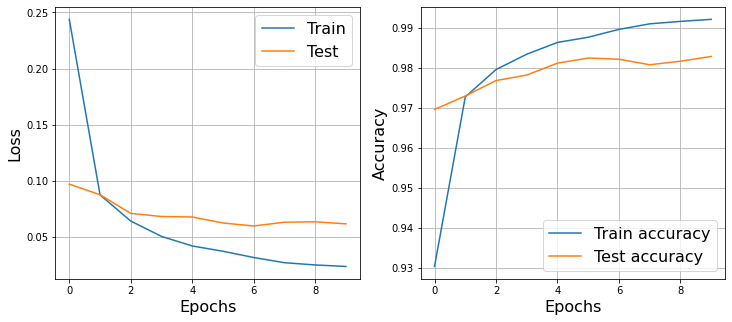

([0.2438376497135742,
  0.08764306220339178,
  0.06427185143679698,
  0.05063629340924529,
  0.04212558670823317,
  0.03738762156319008,
  0.031847725021414586,
  0.027207233692839075,
  0.02522130778654099,
  0.023892552052601688],
 [0.09710383368066594,
  0.08777315353479566,
  0.0710998131905364,
  0.06835518013450163,
  0.06792502257312778,
  0.0625632592960249,
  0.05991329701434632,
  0.06326357815178889,
  0.06362711490298432,
  0.061810150020461106],
 [0.93028164,
  0.97267014,
  0.97951645,
  0.9833644,
  0.9863018,
  0.9876011,
  0.9895667,
  0.9909493,
  0.99156004,
  0.9920709],
 [0.96954113,
  0.9729035,
  0.97676027,
  0.97814476,
  0.9811115,
  0.98239714,
  0.9821005,
  0.980716,
  0.981606,
  0.98279274])

In [51]:
layers = [nn.BatchNorm1d(196), nn.Linear(196, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Linear(128, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Linear(128, 10), nn.ReLU()]
network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.020/0.064	Accuracy: 0.994/0.981


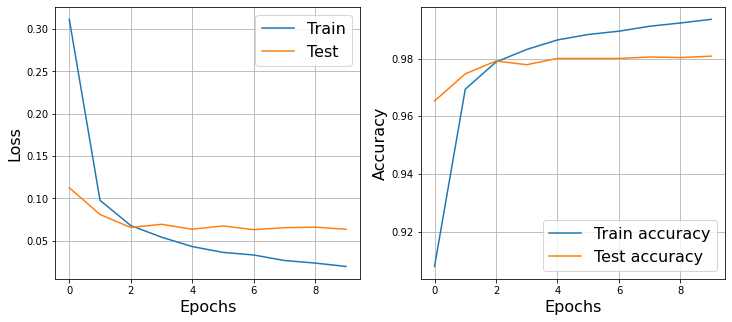

([0.31156608982603434,
  0.09772197096975946,
  0.06792034041176219,
  0.05421861919608197,
  0.04307425998425338,
  0.03622318229882289,
  0.03314723928438138,
  0.026612555156144174,
  0.023575752387508385,
  0.01961474908530208],
 [0.11268154005932657,
  0.08095517690894724,
  0.06570217997731664,
  0.06940619337455003,
  0.06357973889459538,
  0.0674627958620085,
  0.06307135808540956,
  0.0654265583327771,
  0.06602855588536403,
  0.0635660690847855],
 [0.9080046,
  0.96937746,
  0.9787891,
  0.9831368,
  0.9864239,
  0.9883174,
  0.98945564,
  0.99117136,
  0.9922986,
  0.99355346],
 [0.96528876,
  0.9746835,
  0.9791337,
  0.9778481,
  0.98002374,
  0.98002374,
  0.98002374,
  0.9805182,
  0.9803204,
  0.9808149])

In [72]:
layers = [LayerNormalization(), nn.Linear(196, 128), nn.ReLU(), LayerNormalization(), nn.Linear(128, 128), nn.ReLU(), LayerNormalization(), nn.Linear(128, 10), nn.ReLU()]
network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: